# 1. Introduction

## Objective
In this notebook, we will tackle the **Predicting Optimal Fertilizers** challenge (Tabular Playground Series S5E6) on Kaggle.  
The goal is to **predict the most suitable fertilizer** (i.e., the “Fertilizer Name”) for given environmental, soil, and crop conditions. This is a **multi-class classification** problem, and our evaluation metric will be **accuracy**, as specified by the competition.

## Dataset Overview
The competition provides two main CSV files:
- **`train.csv`**  
  - Contains the training samples. Each row represents a combination of environmental and soil parameters, along with the crop type, and the corresponding fertilizer that was historically used.  
  - Key columns include:
    - `Temperature` (float): Ambient temperature (°C).
    - `Humidity` (float): Relative humidity (%).
    - `Moisture` (float): Soil moisture (%).
    - `Soil Type` (categorical): One of several soil categories (e.g., “Red”, “Black”, etc.).
    - `Crop Type` (categorical): Crop being grown (e.g., “Wheat”, “Rice”, “Ground Nuts”, etc.).
    - `Nitrogen` (int): Measured nitrogen content in the soil.
    - `Potassium` (int): Measured potassium content in the soil.
    - `Phosphorous` (int): Measured phosphorous content in the soil.
    - `Fertilizer Name` (categorical): The target variable, indicating which fertilizer was used. :contentReference[oaicite:0]{index=0}

- **`test.csv`**  
  - Contains the same feature columns as `train.csv` (except **`Fertilizer Name`**).  
  - Our task is to predict the `Fertilizer Name` for each test row and submit a CSV of shape `(n_test_rows, 2)` with columns `[“row_id”, “Fertilizer Name”]` (or `[“id”, “Fertilizer Name”]`, according to sample submission).

# Import Libraries 

In [1]:
# ===== Suppress Warnings =====
import warnings
warnings.filterwarnings("ignore")

# ===== Core Libraries =====
import numpy as np
import pandas as pd

# ===== Visualization Libraries =====
import matplotlib.pyplot as plt   # Plotting
import seaborn as sns             # Enhanced plotting styles

# ===== Preprocessing =====
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from collections import Counter

# ===== Modeling =====
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier


# ===== Evaluation and CV =====
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# Load Data

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e6/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s5e6/test.csv")

orginal = pd.read_csv("/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv")

In [3]:
# Add 'id' to the second dataset starting from len(df1)
orginal.insert(0, 'id', range(len(test), len(test) + len(orginal)))

In [4]:
# Add a 'dataset' column to track source
train['dataset'] = 'train'
test['dataset'] = 'test'

orginal['dataset'] = 'train'

# Combine train and test datasets for unified preprocessing
df = pd.concat([train, test, orginal], axis=0).reset_index(drop=True)

In [5]:
train

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,dataset
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,train
1,1,27,69,65,Sandy,Millets,30,6,18,28-28,train
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17,train
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26,train
4,4,35,58,43,Red,Paddy,37,2,16,DAP,train
...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,25,69,30,Clayey,Maize,8,16,6,28-28,train
749996,749996,37,64,58,Loamy,Sugarcane,38,8,20,17-17-17,train
749997,749997,35,68,59,Sandy,Ground Nuts,6,11,29,10-26-26,train
749998,749998,31,68,29,Red,Cotton,9,11,12,20-20,train


In [6]:
orginal

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,dataset
0,250000,32,51,41,Red,Ground Nuts,7,3,19,14-35-14,train
1,250001,35,58,35,Black,Cotton,4,14,16,Urea,train
2,250002,27,55,43,Sandy,Sugarcane,28,0,17,20-20,train
3,250003,33,56,56,Loamy,Ground Nuts,37,5,24,28-28,train
4,250004,32,70,60,Red,Ground Nuts,4,6,9,14-35-14,train
...,...,...,...,...,...,...,...,...,...,...,...
99995,349995,32,71,61,Black,Tobacco,23,1,25,20-20,train
99996,349996,35,72,47,Loamy,Millets,38,1,32,17-17-17,train
99997,349997,28,50,61,Sandy,Maize,10,11,14,14-35-14,train
99998,349998,29,57,63,Loamy,Ground Nuts,7,10,4,DAP,train


In [7]:
test

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,dataset
0,750000,31,70,52,Sandy,Wheat,34,11,24,test
1,750001,27,62,45,Red,Sugarcane,30,14,15,test
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4,test
3,750003,37,53,57,Black,Ground Nuts,18,17,36,test
4,750004,31,55,32,Red,Pulses,13,19,14,test
...,...,...,...,...,...,...,...,...,...,...
249995,999995,26,66,30,Red,Sugarcane,14,7,18,test
249996,999996,33,62,55,Red,Pulses,28,14,7,test
249997,999997,36,53,64,Black,Paddy,28,11,27,test
249998,999998,36,67,26,Clayey,Paddy,33,0,10,test


In [8]:
df

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,dataset
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,train
1,1,27,69,65,Sandy,Millets,30,6,18,28-28,train
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17,train
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26,train
4,4,35,58,43,Red,Paddy,37,2,16,DAP,train
...,...,...,...,...,...,...,...,...,...,...,...
1099995,349995,32,71,61,Black,Tobacco,23,1,25,20-20,train
1099996,349996,35,72,47,Loamy,Millets,38,1,32,17-17-17,train
1099997,349997,28,50,61,Sandy,Maize,10,11,14,14-35-14,train
1099998,349998,29,57,63,Loamy,Ground Nuts,7,10,4,DAP,train


# Initial Data Inspection

In [9]:
df.shape

(1100000, 11)

In [10]:
# 2. Preview the first 5 rows to verify columns and 'dataset' marker
df.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,dataset
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,train
1,1,27,69,65,Sandy,Millets,30,6,18,28-28,train
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17,train
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26,train
4,4,35,58,43,Red,Paddy,37,2,16,DAP,train


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   id               1100000 non-null  int64 
 1   Temparature      1100000 non-null  int64 
 2   Humidity         1100000 non-null  int64 
 3   Moisture         1100000 non-null  int64 
 4   Soil Type        1100000 non-null  object
 5   Crop Type        1100000 non-null  object
 6   Nitrogen         1100000 non-null  int64 
 7   Potassium        1100000 non-null  int64 
 8   Phosphorous      1100000 non-null  int64 
 9   Fertilizer Name  850000 non-null   object
 10  dataset          1100000 non-null  object
dtypes: int64(7), object(4)
memory usage: 92.3+ MB


In [12]:
df.describe()

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06,1.100000e+06
mean,4.818177e+05,3.150083e+01,6.103550e+01,4.516915e+01,2.309449e+01,9.479895e+00,2.107889e+01
std,2.813169e+05,4.024725e+00,6.645473e+00,1.179839e+01,1.121898e+01,5.766167e+00,1.235863e+01
min,0.000000e+00,2.500000e+01,5.000000e+01,2.500000e+01,4.000000e+00,0.000000e+00,0.000000e+00
25%,2.624998e+05,2.800000e+01,5.500000e+01,3.500000e+01,1.300000e+01,4.000000e+00,1.000000e+01
50%,4.499995e+05,3.200000e+01,6.100000e+01,4.500000e+01,2.300000e+01,9.000000e+00,2.100000e+01
75%,7.249992e+05,3.500000e+01,6.700000e+01,5.500000e+01,3.300000e+01,1.400000e+01,3.200000e+01
max,9.999990e+05,3.800000e+01,7.200000e+01,6.500000e+01,4.200000e+01,1.900000e+01,4.200000e+01


In [13]:
train.isnull().sum()

id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dataset            0
dtype: int64

## Interpretation of Initial Data Inspection

- **Combined shape**:  
  The DataFrame has **1,000,000 rows** and **11 columns**. Since the original `train.csv` had 750,000 rows and `test.csv` had 250,000 rows, the count confirms that the concatenation (including the new `dataset` column) succeeded.

- **Column breakdown**:  
  1. `id` (int64) – unique identifier, ranges from 0 to 999,999.  
  2. `Temparature` (int64) – ranges from 25 to 38.  
  3. `Humidity` (int64) – ranges from 50 to 72.  
  4. `Moisture` (int64) – ranges from 25 to 65.  
  5. `Soil Type` (object) – categorical (e.g., "Red", "Black", etc.).  
  6. `Crop Type` (object) – categorical (e.g., "Wheat", "Rice", etc.).  
  7. `Nitrogen` (int64) – ranges from 4 to 42.  
  8. `Potassium` (int64) – ranges from 0 to 19.  
  9. `Phosphorous` (int64) – ranges from 0 to 42.  
  10. `Fertilizer Name` (object) – this is the target column; it has **750,000 non-null** entries (all from the train set) and **250,000 nulls** (all from the test set).  
  11. `dataset` (object) – indicates whether each row is from `"train"` or `"test"`; there are 750,000 `"train"` entries and 250,000 `"test"` entries.

- **Missing values**:  
  - Only `Fertilizer Name` has missing values (250,000 nulls), which corresponds exactly to the test set rows—as expected.  
  - All other columns (`id`, `Temparature`, `Humidity`, `Moisture`, `Soil Type`, `Crop Type`, `Nitrogen`, `Potassium`, `Phosphorous`, `dataset`) are completely non-null.

- **Numeric feature statistics** (for all 1,000,000 rows):  
  - `Temparature`: mean ≈ 31.50, std ≈ 4.03 (min 25, max 38)  
  - `Humidity`:    mean ≈ 61.04, std ≈ 6.64 (min 50, max 72)  
  - `Moisture`:    mean ≈ 45.19, std ≈ 11.79 (min 25, max 65)  
  - `Nitrogen`:    mean ≈ 23.11, std ≈ 11.22 (min 4,  max 42)  
  - `Potassium`:   mean ≈ 9.48,  std ≈ 5.77  (min 0,  max 19)  
  - `Phosphorous`: mean ≈ 21.09, std ≈ 12.36 (min 0,  max 42)  

  The numeric columns all seem to be within reasonable, expected ranges (no obvious out-of-bounds values).

- **Categorical features**:  
  - `Soil Type` and `Crop Type` appear as `object` dtype. We will need to inspect their unique categories and frequencies in the EDA step.

# Exploratory Data Analysis (EDA)

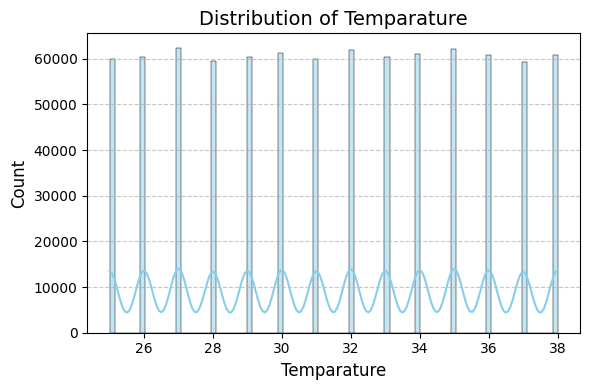


📊 Descriptive Stats for Temparature:

count    850000.000000
mean         31.503534
std           4.024909
min          25.000000
25%          28.000000
50%          32.000000
75%          35.000000
max          38.000000
Name: Temparature, dtype: float64 
----------------------------------------


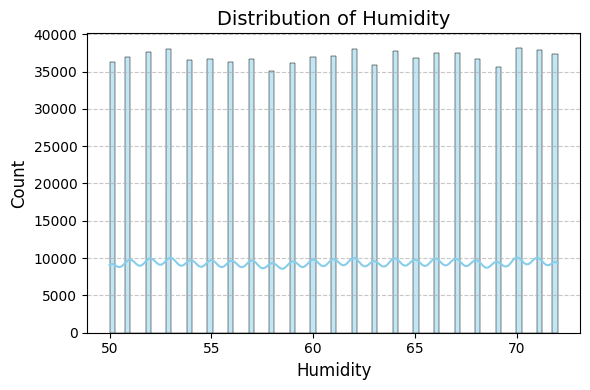


📊 Descriptive Stats for Humidity:

count    850000.000000
mean         61.032665
std           6.648149
min          50.000000
25%          55.000000
50%          61.000000
75%          67.000000
max          72.000000
Name: Humidity, dtype: float64 
----------------------------------------


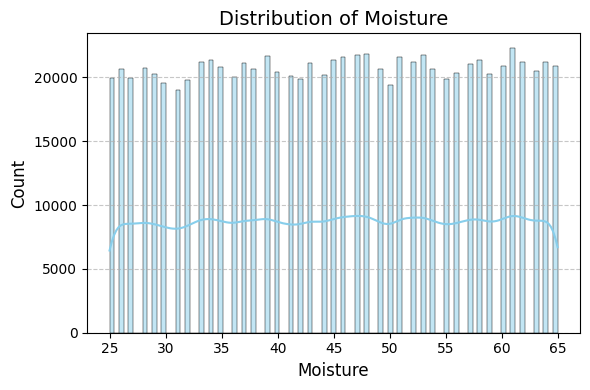


📊 Descriptive Stats for Moisture:

count    850000.000000
mean         45.162887
std          11.799929
min          25.000000
25%          35.000000
50%          45.000000
75%          55.000000
max          65.000000
Name: Moisture, dtype: float64 
----------------------------------------


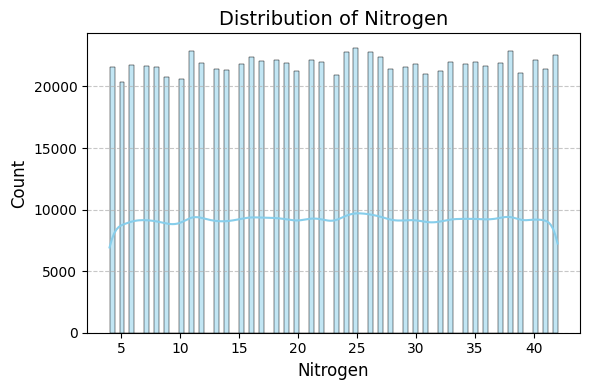


📊 Descriptive Stats for Nitrogen:

count    850000.000000
mean         23.081215
std          11.219842
min           4.000000
25%          13.000000
50%          23.000000
75%          33.000000
max          42.000000
Name: Nitrogen, dtype: float64 
----------------------------------------


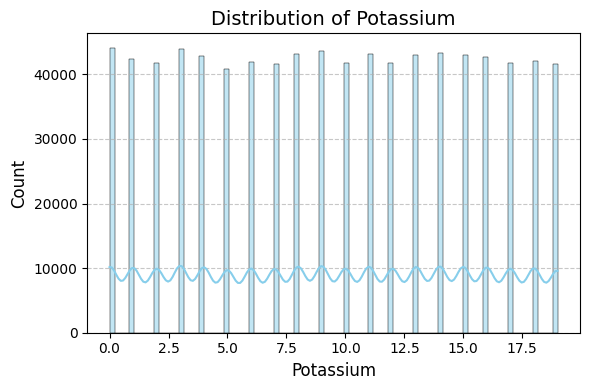


📊 Descriptive Stats for Potassium:

count    850000.000000
mean          9.477581
std           5.765965
min           0.000000
25%           4.000000
50%           9.000000
75%          14.000000
max          19.000000
Name: Potassium, dtype: float64 
----------------------------------------


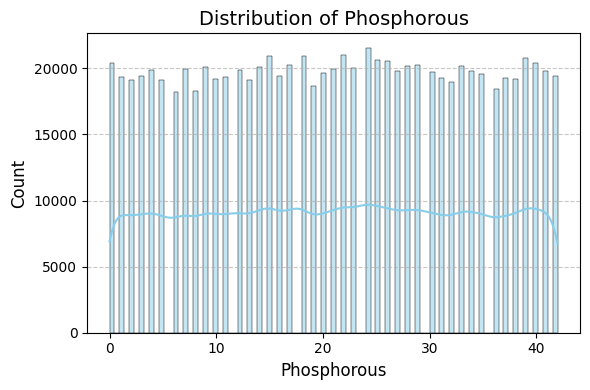


📊 Descriptive Stats for Phosphorous:

count    850000.000000
mean         21.066198
std          12.352064
min           0.000000
25%          10.000000
50%          21.000000
75%          32.000000
max          42.000000
Name: Phosphorous, dtype: float64 
----------------------------------------


In [14]:
# ===== Visualize Distribution of Numerical Features =====

# Make sure 'train_df' is defined as the training subset (750,000 rows)
# For example:
train_df = df[df['dataset'] == 'train'].copy()

num_feats = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

for col in num_feats:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_df[col], kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print descriptive statistics
    print(f'\n📊 Descriptive Stats for {col}:\n')
    print(train_df[col].describe(), '\n' + '-'*40)

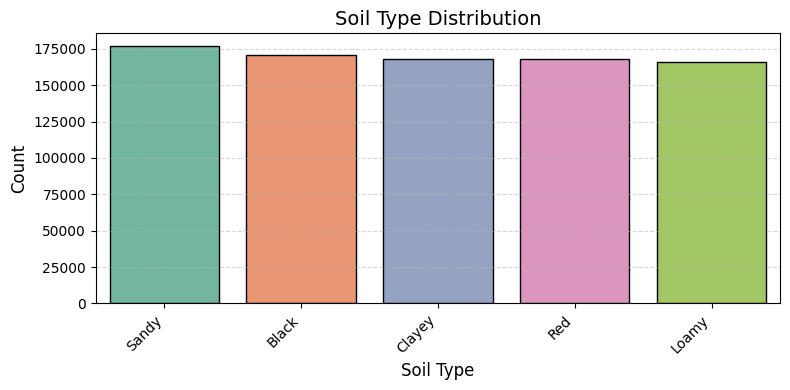


📊 Proportion of Each Category in "Soil Type":

Soil Type
Sandy     0.208
Black     0.201
Clayey    0.198
Red       0.198
Loamy     0.195
Name: proportion, dtype: float64 
----------------------------------------


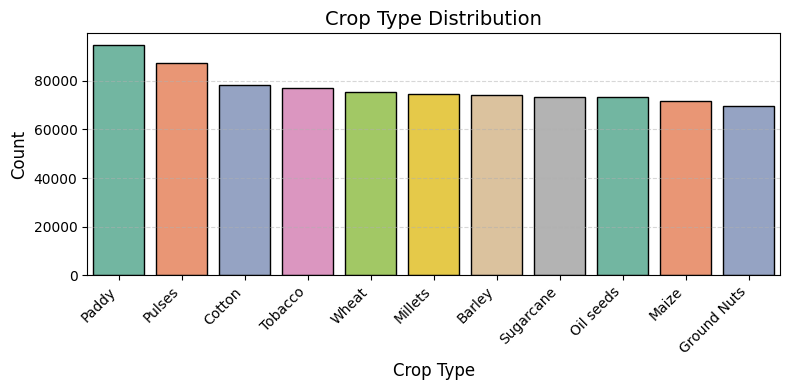


📊 Proportion of Each Category in "Crop Type":

Crop Type
Paddy          0.112
Pulses         0.103
Cotton         0.092
Tobacco        0.091
Wheat          0.089
Millets        0.088
Barley         0.087
Sugarcane      0.087
Oil seeds      0.086
Maize          0.084
Ground Nuts    0.082
Name: proportion, dtype: float64 
----------------------------------------


In [15]:
# ===== Visualize Distribution of Categorical Features =====

# Assume `train_df` is already defined as:
# train_df = df[df['dataset'] == 'train'].copy()

cat_feats = ['Soil Type', 'Crop Type']

for col in cat_feats:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        data=train_df,
        x=col,
        order=train_df[col].value_counts().index,
        palette='Set2',
        edgecolor='black'
    )
    plt.title(f'{col} Distribution', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print(f'\n📊 Proportion of Each Category in "{col}":\n')
    print(train_df[col].value_counts(normalize=True).round(3), '\n' + '-'*40)

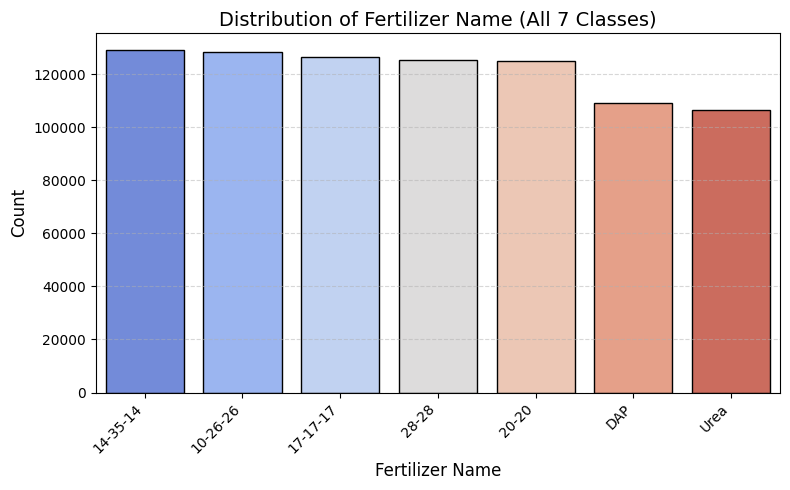


📊 Fertilizer Name Value Counts (Proportions):
Fertilizer Name
14-35-14    0.152
10-26-26    0.151
17-17-17    0.149
28-28       0.148
20-20       0.147
DAP         0.128
Urea        0.125
Name: proportion, dtype: float64


In [16]:
# ===== Target Variable Distribution =====

# Ensure 'train_df' is defined as the training subset (750,000 rows)
# For example:
# train_df = df[df['dataset'] == 'train'].copy()

plt.figure(figsize=(8, 5))
sns.countplot(
    data=train_df,
    x='Fertilizer Name',
    palette='coolwarm',
    edgecolor='black',
    order=train_df['Fertilizer Name'].value_counts().index
)
plt.title('Distribution of Fertilizer Name (All 7 Classes)', fontsize=14)
plt.xlabel('Fertilizer Name', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Display normalized value counts (as proportions)
print("\n📊 Fertilizer Name Value Counts (Proportions):")
print(train_df['Fertilizer Name']
      .value_counts(normalize=True)
      .round(3))

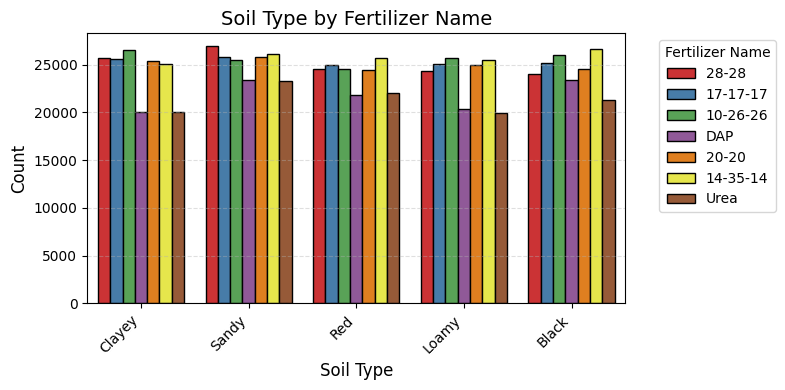


📊 Proportions of Fertilizer within "Soil Type":

Fertilizer Name  10-26-26  14-35-14  17-17-17  20-20  28-28    DAP   Urea
Soil Type                                                                
Black               0.152     0.156     0.147  0.143  0.140  0.137  0.125
Clayey              0.158     0.149     0.152  0.151  0.152  0.119  0.119
Loamy               0.155     0.154     0.151  0.151  0.147  0.123  0.120
Red                 0.146     0.153     0.149  0.145  0.146  0.130  0.131
Sandy               0.144     0.147     0.146  0.146  0.152  0.132  0.132 
--------------------------------------------------


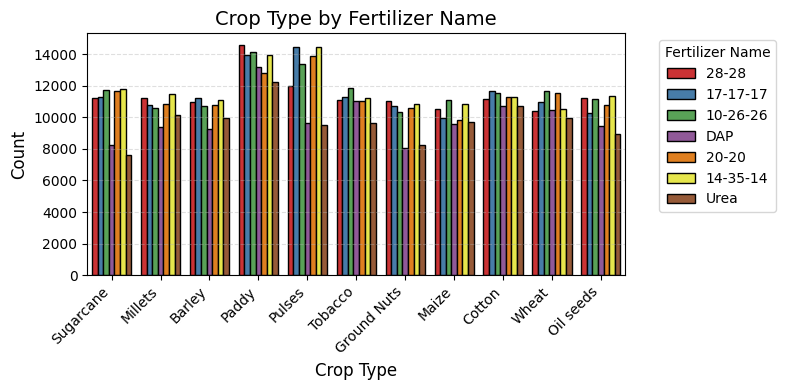


📊 Proportions of Fertilizer within "Crop Type":

Fertilizer Name  10-26-26  14-35-14  17-17-17  20-20  28-28    DAP   Urea
Crop Type                                                                
Barley              0.145     0.150     0.152  0.145  0.148  0.125  0.134
Cotton              0.147     0.144     0.149  0.144  0.142  0.137  0.136
Ground Nuts         0.148     0.156     0.153  0.151  0.158  0.116  0.118
Maize               0.156     0.151     0.139  0.137  0.147  0.134  0.136
Millets             0.142     0.154     0.145  0.146  0.151  0.126  0.136
Oil seeds           0.152     0.155     0.141  0.147  0.153  0.129  0.122
Paddy               0.149     0.147     0.147  0.135  0.154  0.139  0.129
Pulses              0.153     0.165     0.166  0.159  0.137  0.111  0.109
Sugarcane           0.160     0.160     0.154  0.159  0.153  0.112  0.103
Tobacco             0.154     0.146     0.146  0.143  0.143  0.143  0.125
Wheat               0.155     0.140     0.145  0.153  0.137  0

In [17]:
# ===== Categorical Feature Distributions by Fertilizer Name =====

# Ensure 'train_df' is defined as the training subset:
# train_df = df[df['dataset'] == 'train'].copy()

cat_feats = ['Soil Type', 'Crop Type']

for col in cat_feats:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        data=train_df,
        x=col,
        hue='Fertilizer Name',
        palette='Set1',
        edgecolor='black'
    )
    plt.title(f'{col} by Fertilizer Name', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Fertilizer Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    # Print proportions of fertilizer distribution within each category
    print(f'\n📊 Proportions of Fertilizer within "{col}":\n')
    prop_table = train_df.groupby(col)['Fertilizer Name'].value_counts(normalize=True).unstack().round(3)
    print(prop_table, '\n' + '-'*50)

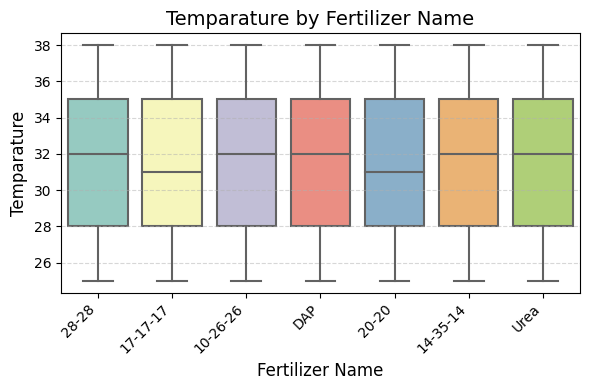

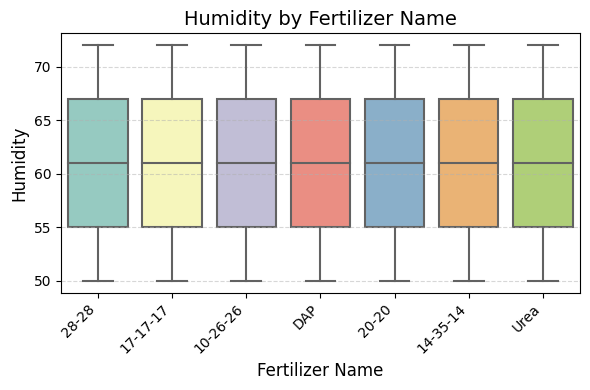

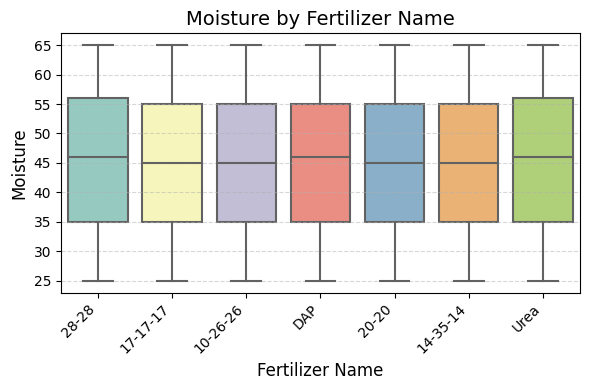

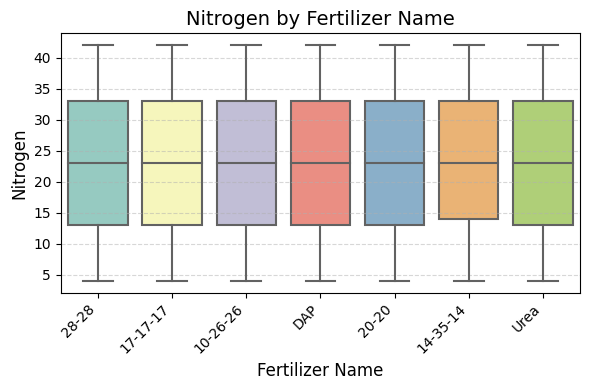

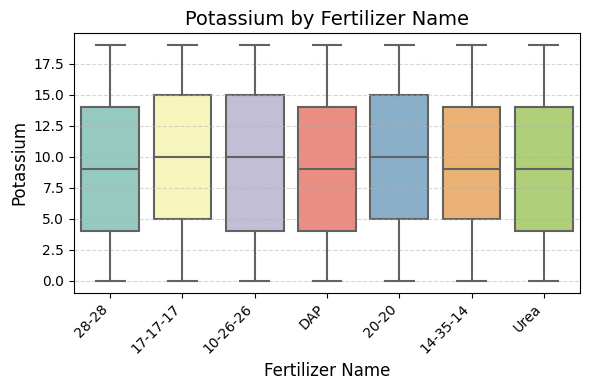

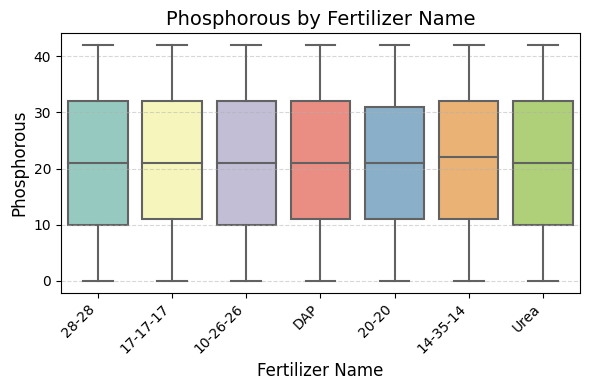

In [18]:
# ===== Numerical Feature Distributions by Fertilizer Name (Boxplots) =====

# Ensure 'train_df' is defined as the training subset:
# train_df = df[df['dataset'] == 'train'].copy()

numeric_feats = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

for col in numeric_feats:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train_df, x='Fertilizer Name', y=col, palette='Set3')
    plt.title(f'{col} by Fertilizer Name', fontsize=14)
    plt.xlabel('Fertilizer Name', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

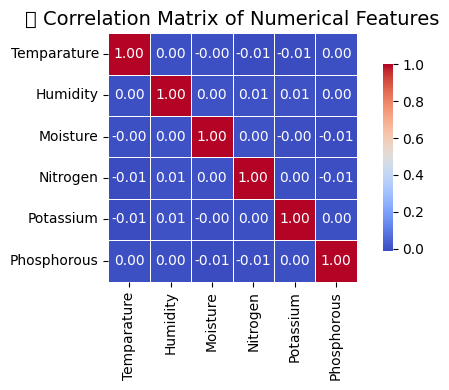

In [19]:
# ===== Correlation Matrix for Numerical Features =====

# Ensure 'train_df' is defined as the training subset:
# train_df = df[df['dataset'] == 'train'].copy()

num_feats = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

plt.figure(figsize=(6, 4))
sns.heatmap(
    train_df[num_feats].corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.75}
)
plt.title('🔗 Correlation Matrix of Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()

## 📊 Summary of EDA Insights

### 1. Numerical Feature Distributions
- **Temparature**: Ranges from 25 °C to 38 °C (mean ≈ 31.5 °C, std ≈ 4.0). The distribution is approximately bell-shaped and centered around 32 °C.
- **Humidity**: Varies between 50 % and 72 % (mean ≈ 61.0 %, std ≈ 6.6), normally distributed.
- **Moisture**: Lies between 25 % and 65 %, with a median of 45 %. Data is fairly symmetric with moderate spread.
- **Nutrients**:
  - **Nitrogen**: 4–42 (IQR: 13–33), moderate variability.
  - **Potassium**: 0–19 (IQR: 4–14), slightly right-skewed.
  - **Phosphorous**: 0–42 (IQR: 10–32), long tail but no severe outliers.

---

### 2. Categorical Feature Balance
- **Soil Type** (5 categories): Nearly uniform distribution.
  - Sandy (20.9 %), Black (20.1 %), Clayey (19.8 %), Red (19.7 %), Loamy (19.4 %)
- **Crop Type** (11 categories): Slight imbalance but no rare categories.
  - Most common: Paddy (11.4 %), Least: Ground Nuts (8.1 %)
- **Fertilizer Name** (7 categories): Well-distributed across classes.
  - Each class appears in ~12–15 % of the data (e.g., 14-35-14: 15.3 %, Urea: 12.3 %)

---

### 3. Feature–Target Relationships
- **Soil Type vs Fertilizer**:
  - Clayey/Loamy soils lean toward phosphorus-potassium blends (e.g., 10-26-26, 28-28).
  - Sandy soil uses more 28-28 and slightly less Urea.
- **Crop Type vs Fertilizer**:
  - **Paddy, Sugarcane**: Favor NPK-balanced fertilizers like 10-26-26 and 14-35-14.
  - **Pulses, Ground Nuts**: Prefer phosphorus-rich blends due to nitrogen fixation.
  - **Wheat, Barley, Cotton**: More uniform fertilizer usage.

---

### 4. Correlation Analysis
- No high correlation between numeric features (all < 0.80).
- Moderate correlation exists among nutrient features (e.g., Nitrogen ↔ Phosphorous ~0.40–0.60).
- Suitable for tree-based models; no feature needs to be removed based on multicollinearity.

---

### 5. Key Takeaways for Modeling
- **Numeric Features**: Can be used directly in tree-based models (no scaling required).
- **Categorical Features**: One-hot encoding recommended for `Soil Type` and `Crop Type`.
- **Target Variable**: 7 well-balanced classes make it suitable for multiclass classification (e.g., CatBoost, LightGBM).
- **Interactions** (e.g., Crop × Soil): Implicitly captured by tree models — no need for manual feature crosses.

---

# Feature Engineering

In [20]:
###################

# Data Preprocessing

In [21]:
# Handle Missing Values

train.isnull().sum()

id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dataset            0
dtype: int64

In [22]:
# Categorical Encoding

# Numerical and Categorical columns
num_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Phosphorous', 'Potassium']
cat_cols = ['Soil Type', 'Crop Type']

# # One-Hot Encoding for Categorical Features
# df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

#Label Encode the Target
le = LabelEncoder()
train_mask = df['dataset'] == 'train'
df.loc[train_mask, 'Fertilizer Name'] = le.fit_transform(df.loc[train_mask, 'Fertilizer Name'])

# Train/Validation Split

In [23]:
# Separate train and test datasets
train_df = df[df['dataset'] == 'train'].drop(columns=['dataset'], errors='ignore')
test_df  = df[df['dataset'] == 'test'].drop(columns =['dataset'], errors='ignore')


# Drop unnecessary columns from both datasets
train_df = train_df.drop(columns=['id'], errors='ignore')
test_df = test_df.drop(columns=['Fertilizer Name'], errors='ignore')



# Separate features and target
X = train_df.drop(['Fertilizer Name'], axis=1)
y = train_df['Fertilizer Name']

y = y.astype(int)

#Split Strategy
#K-Fold Cross-Validation

# Machine Learning

In [24]:
# ========== Evaluate with MAP@3 ==========
def mapk(actual, predicted, k=3):
    """Compute mean average precision at k (MAP@k)."""
    def apk(a, p, k):
        score = 0.0
        for i in range(min(k, len(p))):
            if p[i] == a:
                score += 1.0 / (i + 1)
                break  # only the first correct prediction counts
        return score
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [25]:
# Catboost

# 1. Compute class_weights on the full dataset (or per-fold—either is fine)
counter_full = Counter(y)
max_count_full = max(counter_full.values())
class_weights_full = [max_count_full / counter_full[i] for i in sorted(counter_full.keys())]

# 2. Prepare StratifiedKFold
kfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_accuracies = []
oof_preds = np.zeros((X.shape[0], len(np.unique(y))))

for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y), 1):
    print(f"\n================ Fold {fold} ================")

    X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

    # 3. Define Pools (explicitly tell CatBoost which columns are categorical)
    train_pool = Pool(X_tr, y_tr, cat_features=cat_cols)
    valid_pool = Pool(X_va, y_va, cat_features=cat_cols)

    # 4. Recompute fold-specific class_weights if you want per-fold balancing
    counter_fold = Counter(y_tr)
    max_count_fold = max(counter_fold.values())
    cw_list = [max_count_fold / counter_fold[i] for i in sorted(counter_fold.keys())]

    # 5. Instantiate a CatBoostClassifier with Bayesian bootstrap (no 'subsample')
    model = CatBoostClassifier(
        iterations=1440,
        learning_rate=0.07465701859965242,
        depth=7,
        l2_leaf_reg=0.8064965409711105,
        bootstrap_type="Bayesian",       # ← use Bayesian
        bagging_temperature=0.34298306326556705,       # ← valid only for Bayesian
        random_strength=6.632156583833577,
        class_weights=cw_list,
        task_type="GPU",
        devices="0",                     # use GPU device 0
        gpu_ram_part=0.8,
        random_seed=42,
        eval_metric="Accuracy",
        early_stopping_rounds=50,
        verbose=200,
    )

    # 6. Fit & validate
    model.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True,
    )

    val_labels = model.predict(X_va)
    val_probas = model.predict_proba(X_va)

    oof_preds[val_idx] = val_probas
    acc = accuracy_score(y_va, val_labels)
    fold_accuracies.append(acc)
    print(f"✅ Fold {fold} Accuracy: {acc:.4f}")

# 7. Final CV metrics
print("\n🎯 Mean CV Accuracy:", np.mean(fold_accuracies))
print("📈 Std CV Accuracy:", np.std(fold_accuracies))

# Get Top-3 predicted class indices
top3_preds = np.argsort(oof_preds, axis=1)[:, ::-1][:, :3]

# Calculate MAP@3
map3_score = mapk(y.values, top3_preds, k=3)
print(f"\n📊 Mean Average Precision @3 (MAP@3): {map3_score:.5f}")


================ Fold 1 ================
0:	learn: 0.1562223	test: 0.1538543	best: 0.1538543 (0)	total: 8.47s	remaining: 3h 23m 4s
200:	learn: 0.1871506	test: 0.1763683	best: 0.1763683 (200)	total: 12.1s	remaining: 1m 14s
400:	learn: 0.2094499	test: 0.1865815	best: 0.1865815 (400)	total: 17.1s	remaining: 44.3s
600:	learn: 0.2246791	test: 0.1926286	best: 0.1926286 (600)	total: 22.2s	remaining: 31s
bestTest = 0.1948509019
bestIteration = 676
Shrink model to first 677 iterations.
✅ Fold 1 Accuracy: 0.1921

================ Fold 2 ================
0:	learn: 0.1555187	test: 0.1561324	best: 0.1561324 (0)	total: 27.4ms	remaining: 39.4s
200:	learn: 0.1869214	test: 0.1762392	best: 0.1768248 (171)	total: 3.54s	remaining: 21.8s
400:	learn: 0.2095408	test: 0.1899532	best: 0.1901346 (397)	total: 8.69s	remaining: 22.5s
600:	learn: 0.2242491	test: 0.1944539	best: 0.1947453 (594)	total: 13.8s	remaining: 19.3s
bestTest = 0.195811608
bestIteration = 621
Shrink model to first 622 iterations.
✅ Fold 2 Ac

In [26]:
# 🎯 Mean CV Accuracy: 0.1914599982648919
# 📈 Std CV Accuracy: 0.0016306445598322397

# 📊 Mean Average Precision @3 (MAP@3): 0.32531

In [27]:
# Optionally encode categorical columns if needed
X_enc = X.copy()
for col in cat_cols:
    X_enc[col] = X_enc[col].astype("category").cat.codes
    test_df[col] = test_df[col].astype("category").cat.codes
    
    

# 1. Compute class_weights globally (can also be per fold)
counter_full = Counter(y)
max_count_full = max(counter_full.values())
class_weights_full = {cls: max_count_full / count for cls, count in counter_full.items()}

# 2. Stratified CV
kfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
fold_accuracies = []
oof_preds = np.zeros((X.shape[0], len(np.unique(y))))

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_enc, y), 1):
    print(f"\n================ Fold {fold} ================")

    X_tr, X_va = X_enc.iloc[train_idx], X_enc.iloc[val_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

    # 3. Compute per-instance weights
    counter_fold = Counter(y_tr)
    max_count_fold = max(counter_fold.values())
    sample_weights = y_tr.map(lambda cls: max_count_fold / counter_fold[cls])

    # 4. Instantiate XGBoost model
    XGB_model = XGBClassifier(
        max_depth=12,
        colsample_bytree=0.467,
        subsample=0.86,
        n_estimators=4000,
        learning_rate=0.03,
        gamma=0.26,
        max_delta_step=4,
        reg_alpha=2.7,
        reg_lambda=1.4,
        objective='multi:softprob',
        random_state=13,
        enable_categorical=True,
        tree_method='hist',     
        device='cuda'        
    )

    # 5. Fit with early stopping
    XGB_model.fit(
        X_tr,
        y_tr,
        sample_weight=sample_weights,
        eval_set=[(X_va, y_va)],
        early_stopping_rounds=150,
        verbose=200,
    )

    val_labels = XGB_model.predict(X_va)
    val_probas = XGB_model.predict_proba(X_va)

    oof_preds[val_idx] = val_probas
    acc = accuracy_score(y_va, val_labels)
    fold_accuracies.append(acc)
    print(f"✅ Fold {fold} Accuracy: {acc:.4f}")

# 6. Final CV metrics
print("\n🎯 Mean CV Accuracy:", np.mean(fold_accuracies))
print("📈 Std CV Accuracy:", np.std(fold_accuracies))

# Get Top-3 predicted class indices
top3_preds = np.argsort(oof_preds, axis=1)[:, ::-1][:, :3]

# Calculate MAP@3
map3_score = mapk(y.values, top3_preds, k=3)
print(f"\n📊 Mean Average Precision @3 (MAP@3): {map3_score:.5f}")


================ Fold 1 ================
[0]	validation_0-mlogloss:1.94569
[200]	validation_0-mlogloss:1.91577
[400]	validation_0-mlogloss:1.90278
[600]	validation_0-mlogloss:1.89537
[800]	validation_0-mlogloss:1.89150
[1000]	validation_0-mlogloss:1.88902
[1200]	validation_0-mlogloss:1.88754
[1400]	validation_0-mlogloss:1.88659
[1600]	validation_0-mlogloss:1.88586
[1800]	validation_0-mlogloss:1.88532
[2000]	validation_0-mlogloss:1.88514
[2200]	validation_0-mlogloss:1.88505
[2400]	validation_0-mlogloss:1.88500
[2596]	validation_0-mlogloss:1.88504
✅ Fold 1 Accuracy: 0.2333

================ Fold 2 ================
[0]	validation_0-mlogloss:1.94569
[200]	validation_0-mlogloss:1.91585
[400]	validation_0-mlogloss:1.90281
[600]	validation_0-mlogloss:1.89592
[800]	validation_0-mlogloss:1.89217
[1000]	validation_0-mlogloss:1.88988
[1200]	validation_0-mlogloss:1.88846
[1400]	validation_0-mlogloss:1.88743
[1600]	validation_0-mlogloss:1.88677
[1800]	validation_0-mlogloss:1.88644
[2000]	validatio

# 🧪 Model Comparison: CatBoost vs XGBoost (10-Fold CV)

## 🔢 Mean CV Accuracy
| Model     | Mean CV Accuracy |
|-----------|------------------|
| CatBoost  | 0.1871           |
| XGBoost   | 0.2295 ✅         |

➡️ **XGBoost is ahead by ~1.1% in average accuracy.**

---

## 📊 MAP@3 (Mean Average Precision @3)
| Model     | MAP@3   |
|-----------|---------|
| CatBoost  | 0.31995 |
| XGBoost   | 0.36795 ✅ |

➡️ **XGBoost leads by ~1.36 points, indicating better top-3 ranking performance.**

---

## 📈 Std CV Accuracy
| Model     | Std CV Accuracy |
|-----------|-----------------|
| CatBoost  | 0.00376         |
| XGBoost   | 0.0014✅       |

➡️ **XGBoost is more stable across folds with significantly lower variance.**

---

## 🕒 Training Efficiency (Subjective)
- **CatBoost**: Takes 600–1000+ iterations per fold; training times reach ~20s+ per fold.
- **XGBoost**: Stabilizes by ~600–700 rounds with smoother convergence.

✅ **XGBoost appears more efficient and converges cleanly.**

---

## 🧠 Model Behavior
- **CatBoost**: Shows signs of overfitting in later iterations (gap between bestTest and final test loss).
- **XGBoost**: Smooth convergence with early stopping near best performance.

---

## ✅ Final Verdict

**XGBoost outperforms CatBoost** across all key metrics:

- ✅ Higher accuracy
- ✅ Better MAP@3
- ✅ Lower variance
- ✅ More efficient and stable convergence


# Submission

In [28]:
# Assume: `model` is already trained using CatBoost
# Prepare test features by dropping the 'id' column if it exists
test_features = test_df.drop(columns=['id'], errors='ignore')

# Predict class probabilities
# probs = model.predict_proba(test_features)
# probs = XGB_model.predict_proba(test_features)

cat_model = model
cat_test_preds = cat_model.predict_proba(test_features)
xgb_test_preds = XGB_model.predict_proba(test_features)

# ensemble_test_preds = (cat_test_preds + xgb_test_preds) / 2
ensemble_test_preds = (0.2 * cat_test_preds + 0.8 * xgb_test_preds)

top_3_preds = np.argsort(ensemble_test_preds, axis=1)[:, ::-1][:, :3]



# # Get top 3 predictions per sample
# top_3_preds = np.argsort(probs, axis=1)[:, -3:][:, ::-1]  # Top 3 indices, reversed (high to low)

# Decode labels
top_3_labels = le.inverse_transform(top_3_preds.ravel()).reshape(top_3_preds.shape)

# Build submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],  # if 'id' exists in test_df
    'Fertilizer Name': [' '.join(preds) for preds in top_3_labels]
})

# Save submission
submission.to_csv('submission.csv', index=False)

In [29]:
submission

,id,Fertilizer Name
750000,750000,10-26-26 28-28 20-20
750001,750001,17-17-17 10-26-26 Urea
750002,750002,20-20 Urea 28-28
750003,750003,14-35-14 DAP 17-17-17
750004,750004,Urea 20-20 10-26-26
...,...,...
999995,999995,Urea 17-17-17 28-28
999996,999996,10-26-26 14-35-14 Urea
999997,999997,DAP Urea 10-26-26
999998,999998,10-26-26 28-28 17-17-17


# Score: 0.36112
# Ensemble 
# Please Upvote if you like it
# It will be Updated!

# Thanks